In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve
from scipy import integrate
import warnings
import traceback

## airPLS Implementation

In [11]:
def WhittakerSmooth(x, w, lambda_, differences=1):
    """Whittaker smoothing function, internal to airPLS algorithm.
    
    Parameters:
    -----------
    x : array-like
        Input signal
    w : array-like
        Weights array
    lambda_ : float
        Smoothing parameter
    differences : int
        Order of differences
    
    Returns:
    --------
    background : array-like
        Smoothed signal
    """
    X = np.matrix(x)
    m = X.size
    E = eye(m, format='csc')
    for i in range(differences):
        E = E[1:] - E[:-1]
    W = diags(w, 0, shape=(m,m))
    
    A = csc_matrix(W + (lambda_ * E.T * E))
    B = csc_matrix(W * X.T)
    
    try:
        background = spsolve(A, B)
    except Exception as e:
        print(f"Error in spsolve: {str(e)}")
        return None, None, None, None
        
    return np.array(background), W, A, B

def airPLS(x, lambda_=100, porder=1, itermax=15, tol=0.001, normalization=False):
    """Adaptive iteratively reweighted penalized least squares for baseline correction.
    
    Parameters:
    -----------
    x : array-like
        Input spectrum
    lambda_ : float
        Smoothing parameter, controls the smoothness of the fitted baseline
    porder : int
        Order of differences
    itermax : int
        Maximum number of iterations
    tol : float
        Tolerance parameter for convergence
    normalization : bool
        Whether to apply normalization to the input spectrum
    
    Returns:
    --------
    z : array-like
        Baseline estimation
    """
    try:
        m = x.shape[0]
        if normalization:
            original_spectrum = x.copy()
            # Try auto area normalization
            wavenumber = np.arange(m)  # Fake wavenumber for normalization
            # Check for NaN or inf values
            if np.any(np.isnan(x)) or np.any(np.isnan(wavenumber)) or np.any(np.isinf(x)) or np.any(np.isinf(wavenumber)):
                print("Warning: NaN or inf values detected in the data")
            else:
                # Calculate the area using trapezoidal rule
                scaling_factor = integrate.trapz(x, wavenumber)
                if scaling_factor == 0:
                    scaling_factor = 1
                    print("Warning: Area is zero, using original spectrum")
                
                # Normalize the spectrum
                normalized_x = x / scaling_factor
        else:
            normalized_x = x  # Just to avoid undefined variable errors
        
        weights = np.ones(m)

        for i in range(1, itermax+1):
            if normalization:
                z, W, A, B = WhittakerSmooth(normalized_x, weights, lambda_, porder)
            else:
                z, W, A, B = WhittakerSmooth(x, weights, lambda_, porder)
                
            if z is None:
                print(f"WhittakerSmooth failed at iteration {i}")
                return None
            
            if normalization:
                d = normalized_x - z
            else:
                d = x - z
            dssn = np.abs(d[d<0].sum())

            if normalization:
                if(dssn < tol * (abs(normalized_x)).sum() or i == itermax):
                    break
            else:
                if(dssn < tol * (abs(x)).sum() or i == itermax):
                    break
                    
            weights[d>=0] = 0

            try:
                with warnings.catch_warnings(record=True) as caught_warnings:
                    warnings.simplefilter("always")
                    if np.isinf(dssn):
                        dssn = np.finfo(dssn.dtype).max
                    exp_term = i * np.abs(d[d<0]) / dssn
                    max_exp = 709  # round(np.log(np.finfo(float).max))
                    exp_term = np.minimum(exp_term, max_exp)
                    weights[d<0] = np.exp(exp_term)
                    if caught_warnings:
                        warning = caught_warnings[0]
                        print(f"Warning at iteration {i} in exp calculation: {warning.message}")
            except Exception as e:
                print(f"Exception at iteration {i} in exp calculation: {e}")
                if normalization:
                    normalized_original_spectrum = original_spectrum / scaling_factor
                    normalized_predicted_x = normalized_original_spectrum - z
                    unnormalized_predicted_x = normalized_predicted_x * scaling_factor
                    z = original_spectrum - unnormalized_predicted_x
                return z

            try:
                if np.isinf(dssn):
                    dssn = np.finfo(dssn.dtype).max
                weights[0] = np.exp(i * (d[d<0]).max() / dssn)
            except Warning as warn:
                print(f"Warning at iteration {i} in w[0] calculation: {warn}")
                if normalization:
                    normalized_original_spectrum = original_spectrum / scaling_factor
                    normalized_predicted_x = normalized_original_spectrum - z
                    unnormalized_predicted_x = normalized_predicted_x * scaling_factor
                    z = original_spectrum - unnormalized_predicted_x
                return z

            weights[-1] = weights[0]

        if normalization:
            normalized_original_spectrum = original_spectrum / scaling_factor
            normalized_predicted_x = normalized_original_spectrum - z
            unnormalized_predicted_x = normalized_predicted_x * scaling_factor
            z = original_spectrum - unnormalized_predicted_x
        return z
    except Exception as e:
        print(f"Error in airPLS: {str(e)}")
        print(f"Traceback: {traceback.format_exc()}")
        return None

## Model Loading Functions

In [12]:
def flexible_load_model_components(model_dir, model_file=None, pca_file=None, 
                                  lambda_scaler_file=None, tau_scaler_file=None):
    """Load model components with flexible file naming.
    
    Parameters:
    -----------
    model_dir : str
        Base directory for model files
    model_file : str or None
        Name of model file (or full path if not in model_dir)
    pca_file : str or None
        Name of PCA file (or full path if not in model_dir)
    lambda_scaler_file : str or None
        Name of lambda scaler file (or full path if not in model_dir)
    tau_scaler_file : str or None
        Name of tau scaler file (or full path if not in model_dir)
        
    Returns:
    --------
    model, pca, lambda_scaler, tau_scaler : Model components or None if not found
    """
    # Initialize variables
    model = None
    pca = None
    lambda_scaler = None
    tau_scaler = None
    
    # Define default filenames
    default_model_file = "PCA_RF_model.pkl"
    default_pca_file = "pca_transform.pkl"
    default_lambda_scaler_file = "lambda_scaler.pkl"
    default_tau_scaler_file = "tau_scaler.pkl"
    
    # Use default filenames if not specified
    if not model_file:
        model_file = default_model_file
    if not pca_file:
        pca_file = default_pca_file
    if not lambda_scaler_file:
        lambda_scaler_file = default_lambda_scaler_file
    if not tau_scaler_file:
        tau_scaler_file = default_tau_scaler_file
    
    # Determine if paths are absolute or relative to model_dir
    model_path = model_file if os.path.isabs(model_file) else os.path.join(model_dir, model_file)
    pca_path = pca_file if os.path.isabs(pca_file) else os.path.join(model_dir, pca_file)
    lambda_scaler_path = lambda_scaler_file if os.path.isabs(lambda_scaler_file) else os.path.join(model_dir, lambda_scaler_file)
    tau_scaler_path = tau_scaler_file if os.path.isabs(tau_scaler_file) else os.path.join(model_dir, tau_scaler_file)
    
    # Try to load each component and report success/failure
    print(f"Looking for model files...")
    
    try:
        if os.path.exists(model_path):
            print(f"Loading model from: {model_path}")
            model = joblib.load(model_path)
            print(f"✓ Model loaded successfully: {type(model).__name__}")
        else:
            print(f"✗ Model file not found: {model_path}")
            # Try to find any .pkl files in the directory
            pkl_files = [f for f in os.listdir(model_dir) if f.endswith('.pkl')]
            if pkl_files:
                print(f"  Found these .pkl files in {model_dir}:")
                for f in pkl_files:
                    print(f"  - {f}")
    except Exception as e:
        print(f"✗ Error loading model: {str(e)}")
    
    try:
        if os.path.exists(pca_path):
            print(f"Loading PCA from: {pca_path}")
            pca = joblib.load(pca_path)
            print(f"✓ PCA loaded successfully")
            if hasattr(pca, 'n_components_'):
                print(f"  PCA components: {pca.n_components_}")
            if hasattr(pca, 'mean_'):
                print(f"  PCA expects data of length: {len(pca.mean_)}")
        else:
            print(f"✗ PCA file not found: {pca_path}")
    except Exception as e:
        print(f"✗ Error loading PCA: {str(e)}")
    
    try:
        if os.path.exists(lambda_scaler_path):
            print(f"Loading lambda scaler from: {lambda_scaler_path}")
            lambda_scaler = joblib.load(lambda_scaler_path)
            print(f"✓ Lambda scaler loaded successfully")
        else:
            print(f"✗ Lambda scaler file not found: {lambda_scaler_path}")
    except Exception as e:
        print(f"✗ Error loading lambda scaler: {str(e)}")
    
    try:
        if os.path.exists(tau_scaler_path):
            print(f"Loading tau scaler from: {tau_scaler_path}")
            tau_scaler = joblib.load(tau_scaler_path)
            print(f"✓ Tau scaler loaded successfully")
        else:
            print(f"✗ Tau scaler file not found: {tau_scaler_path}")
    except Exception as e:
        print(f"✗ Error loading tau scaler: {str(e)}")
    
    # Final check
    if model is None or pca is None or lambda_scaler is None or tau_scaler is None:
        print("\n⚠️ Not all model components were loaded successfully.")
        return None, None, None, None
    else:
        print("\n✓ All model components loaded successfully!")
        return model, pca, lambda_scaler, tau_scaler

## Spectrum Loading Function

In [13]:
def load_spectrum(file_path, spectrum_idx=1):
    """Load a spectrum from a CSV file.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing spectra
    spectrum_idx : int
        Index of the spectrum to load (1-based index for columns)
        
    Returns:
    --------
    wavenumbers : array-like
        Wavenumber values
    spectrum : array-like
        Intensity values
    """
    try:
        print(f"Loading spectrum from {file_path}")
        # Load CSV file
        data = pd.read_csv(file_path)
        
        # Print column names for debugging
        print(f"CSV columns: {data.columns.tolist()}")
        
        # Assuming first column is wavenumbers and subsequent columns are spectra
        wavenumbers = data.iloc[:, 0].values
        
        # Check if spectrum_idx is valid
        if spectrum_idx >= data.shape[1]:
            print(f"Warning: spectrum_idx {spectrum_idx} is out of range. Using column 1 instead.")
            spectrum_idx = 1
            
        spectrum = data.iloc[:, spectrum_idx].values
        
        # Print some basic info
        print(f"Loaded spectrum with {len(spectrum)} data points")
        print(f"Wavenumber range: {wavenumbers[0]} to {wavenumbers[-1]}")
        
        # Check for NaN or Inf values
        if np.any(np.isnan(spectrum)) or np.any(np.isinf(spectrum)):
            print("Warning: NaN or Inf values found in spectrum. Replacing with zeros.")
            spectrum = np.nan_to_num(spectrum, nan=0.0, posinf=0.0, neginf=0.0)
        
        return wavenumbers, spectrum
    except Exception as e:
        print(f"Error loading spectrum: {str(e)}")
        print(traceback.format_exc())
        return None, None

## Prediction Functions

In [14]:
def predict_airpls_params(spectrum, pca, model, lambda_scaler, tau_scaler):
    """Predict optimal airPLS parameters for a given spectrum using the pre-trained model.
    
    Parameters:
    -----------
    spectrum : array-like
        Input spectrum
    pca : PCA object
        Pre-trained PCA transformation
    model : sklearn model
        Pre-trained prediction model
    lambda_scaler : MinMaxScaler
        Scaler for lambda parameter
    tau_scaler : MinMaxScaler
        Scaler for tau parameter
        
    Returns:
    --------
    lambda_val : float
        Predicted lambda parameter
    tau_val : float
        Predicted tau parameter
    """
    try:
        # Make a copy of the spectrum to avoid modifying the original
        spectrum_copy = spectrum.copy()
        
        # Check if PCA object has the expected length attribute
        if hasattr(pca, 'mean_'):
            expected_length = len(pca.mean_)
            print(f"Expected spectrum length from PCA: {expected_length}")
            print(f"Actual spectrum length: {len(spectrum_copy)}")
            
            # Handle spectrum length mismatch if needed
            if len(spectrum_copy) != expected_length:
                if len(spectrum_copy) > expected_length:
                    print(f"Truncating spectrum from {len(spectrum_copy)} to {expected_length} points")
                    spectrum_copy = spectrum_copy[:expected_length]
                else:
                    print(f"Padding spectrum from {len(spectrum_copy)} to {expected_length} points")
                    spectrum_copy = np.pad(spectrum_copy, 
                                         (0, expected_length - len(spectrum_copy)), 
                                         mode='constant',
                                         constant_values=0)
        else:
            print("Warning: PCA object doesn't have mean_ attribute. Proceeding with original spectrum length.")
        
        # Reshape for model input (flatten in case it's not already 1D)
        X = spectrum_copy.reshape(1, -1)
        
        print(f"Input shape for PCA: {X.shape}")
        
        # Apply PCA transformation
        X_pca = pca.transform(X)
        
        print(f"PCA transformed shape: {X_pca.shape}")
        
        # Make prediction (normalized values)
        predicted_normalized = model.predict(X_pca)
        predicted_normalized = np.clip(predicted_normalized, 0, 1)  # Clip to [0, 1]
        
        print(f"Predicted normalized values: {predicted_normalized}")
        
        # Inverse transform to get original scale (log values)
        lambda_log = lambda_scaler.inverse_transform(predicted_normalized[:, 0].reshape(-1, 1))
        tau_log = tau_scaler.inverse_transform(predicted_normalized[:, 1].reshape(-1, 1))
        
        # Convert from log to linear
        lambda_val = 10**lambda_log[0, 0]
        tau_val = 10**tau_log[0, 0]
        
        return lambda_val, tau_val
    
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        print(traceback.format_exc())
        return None, None

def apply_baseline_correction(wavenumbers, spectrum, lambda_val, tau_val, porder=2, itermax=1000): #p=2为默认的参数，调用的时候赋值为多少就是多少
    """Apply baseline correction using the airPLS algorithm.
    
    Parameters:
    -----------
    wavenumbers : array-like
        Wavenumber values
    spectrum : array-like
        Intensity values
    lambda_val : float
        Lambda parameter for airPLS
    tau_val : float
        Tau parameter for airPLS
    porder : int
        Order of differences
    itermax : int
        Maximum number of iterations
        
    Returns:
    --------
    corrected_spectrum : array-like
        Baseline-corrected spectrum
    baseline : array-like
        Estimated baseline
    """
    # Apply airPLS
    baseline = airPLS(
        spectrum,
        lambda_=lambda_val,
        porder=porder,
        itermax=itermax,
        tol=tau_val,
        normalization=False
    )
    
    if baseline is None:
        print("Error: Baseline estimation failed.")
        return None, None
    
    # Calculate corrected spectrum
    corrected_spectrum = spectrum - baseline
    
    return corrected_spectrum, baseline

## Visualization Functions

In [15]:
def plot_spectrum(wavenumbers, spectrum, title="Spectrum", xlabel="Wavenumber", ylabel="Intensity", figsize=(10, 6)):
    """Plot a spectrum.
    
    Parameters:
    -----------
    wavenumbers : array-like
        Wavenumber values
    spectrum : array-like
        Intensity values
    title : str
        Plot title
    xlabel : str
        X-axis label
    ylabel : str
        Y-axis label
    figsize : tuple
        Figure size
    """
    plt.figure(figsize=figsize)
    plt.plot(wavenumbers, spectrum)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_baseline_comparison(wavenumbers, spectrum, baseline_pred, baseline_default=None, 
                           title="Baseline Comparison", figsize=(12, 10)):
    """Plot baseline comparison and correction.
    
    Parameters:
    -----------
    wavenumbers : array-like
        Wavenumber values
    spectrum : array-like
        Original spectrum
    baseline_pred : array-like
        Baseline predicted using the model
    baseline_default : array-like or None
        Baseline calculated using default parameters
    title : str
        Plot title
    figsize : tuple
        Figure size
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    fig.suptitle(title)
    
    # Plot original spectrum with baselines
    ax1.plot(wavenumbers, spectrum, 'k-', label='Original')
    ax1.plot(wavenumbers, baseline_pred, 'r--', label='Predicted Baseline')
    
    if baseline_default is not None:
        ax1.plot(wavenumbers, baseline_default, 'b--', label='Default Baseline')
    
    ax1.set_title('Spectrum with Fitted Baselines')
    ax1.set_xlabel('Wavenumber')
    ax1.set_ylabel('Intensity')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot baseline-corrected spectra
    corrected_pred = spectrum - baseline_pred
    ax2.plot(wavenumbers, corrected_pred, 'r-', label='Predicted Parameters')
    
    if baseline_default is not None:
        corrected_default = spectrum - baseline_default
        ax2.plot(wavenumbers, corrected_default, 'b-', label='Default Parameters')
    
    ax2.set_title('Baseline-Corrected Spectra')
    ax2.set_xlabel('Wavenumber')
    ax2.set_ylabel('Intensity')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Main Processing Pipeline

In [16]:
def process_spectrum(wavenumbers, spectrum, model, pca, lambda_scaler, tau_scaler, 
                   compare_default=True, save_results=True, output_dir="results"):
    """Process a spectrum using the model.
    
    Parameters:
    -----------
    wavenumbers : array-like
        Wavenumber values
    spectrum : array-like
        Intensity values
    model : sklearn model
        Pre-trained prediction model
    pca : PCA object
        Pre-trained PCA transformation
    lambda_scaler : MinMaxScaler
        Scaler for lambda parameter
    tau_scaler : MinMaxScaler
        Scaler for tau parameter
    compare_default : bool
        Whether to compare with default parameters
    save_results : bool
        Whether to save the results
    output_dir : str
        Directory to save results
        
    Returns:
    --------
    results_dict : dict
        Dictionary containing processing results
    """
    results_dict = {
        'wavenumbers': wavenumbers,
        'original_spectrum': spectrum,
        'lambda_val': None,
        'tau_val': None,
        'baseline_pred': None,
        'corrected_pred': None,
        'baseline_default': None,
        'corrected_default': None
    }
    
    # Predict optimal parameters
    lambda_val, tau_val = predict_airpls_params(
        spectrum, pca, model, lambda_scaler, tau_scaler
    )
    
    if lambda_val is None or tau_val is None:
        print("Error: Failed to predict parameters.")
        return results_dict
    
    results_dict['lambda_val'] = lambda_val
    results_dict['tau_val'] = tau_val
    
    print(f"Predicted parameters:")
    print(f"  Lambda: {lambda_val:.6e}")
    print(f"  Tau: {tau_val:.6e}")
    
    # Apply baseline correction with predicted parameters
    corrected_pred, baseline_pred = apply_baseline_correction(
        wavenumbers, spectrum, lambda_val, tau_val
    )
    
    if corrected_pred is None or baseline_pred is None:
        print("Error: Failed to apply baseline correction with predicted parameters.")
        return results_dict
    
    results_dict['baseline_pred'] = baseline_pred
    results_dict['corrected_pred'] = corrected_pred
    
    # Apply baseline correction with default parameters for comparison
    if compare_default:
        corrected_default, baseline_default = apply_baseline_correction(
            wavenumbers, spectrum, 100, 0.001, porder=1, itermax=15
        )
        
        if corrected_default is not None and baseline_default is not None:
            results_dict['baseline_default'] = baseline_default
            results_dict['corrected_default'] = corrected_default
    
    # Save results if requested
    if save_results:
        # Create output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        # Create DataFrame with results
        results_df = pd.DataFrame({
            "Wavenumber": wavenumbers,
            "Original": spectrum,
            "Predicted_Baseline": baseline_pred,
            "Corrected_Predicted": corrected_pred
        })
        
        if compare_default and baseline_default is not None:
            results_df["Default_Baseline"] = baseline_default
            results_df["Corrected_Default"] = corrected_default
        
        # Save to CSV
        results_path = os.path.join(output_dir, "baseline_correction_results.csv")
        results_df.to_csv(results_path, index=False)
        print(f"Results saved to {results_path}")
        
        # Save parameters
        params_df = pd.DataFrame({
            "Parameter": ["lambda", "tau"],
            "Value": [lambda_val, tau_val]
        })
        
        params_path = os.path.join(output_dir, "predicted_parameters.csv")
        params_df.to_csv(params_path, index=False)
        print(f"Parameters saved to {params_path}")
        
    return results_dict

def process_multiple_spectra(file_path, model, pca, lambda_scaler, tau_scaler, output_dir="results"):
    """Process multiple spectra from a file.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing spectra
    model : sklearn model
        Pre-trained prediction model
    pca : PCA object
        Pre-trained PCA transformation
    lambda_scaler : MinMaxScaler
        Scaler for lambda parameter
    tau_scaler : MinMaxScaler
        Scaler for tau parameter
    output_dir : str
        Directory to save results
        
    Returns:
    --------
    all_results : dict
        Dictionary containing all processing results
    """
    try:
        # Load CSV file
        data = pd.read_csv(file_path)
        
        # Get wavenumbers from first column
        wavenumbers = data.iloc[:, 0].values
        
        # Create output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        # Process each spectrum
        all_results = {}
        all_params = []
        
        for i in range(1, data.shape[1]):
            try:
                # Extract spectrum
                spectrum = data.iloc[:, i].values
                spectrum_name = data.columns[i] if i < len(data.columns) else f"Spectrum_{i}"
                
                print(f"\nProcessing {spectrum_name}...")
                
                # Create subdirectory for this spectrum
                spectrum_dir = os.path.join(output_dir, f"{spectrum_name}")
                if not os.path.exists(spectrum_dir):
                    os.makedirs(spectrum_dir)
                
                # Process the spectrum
                results = process_spectrum(
                    wavenumbers, spectrum, model, pca, lambda_scaler, tau_scaler,
                    compare_default=True, save_results=False
                )
                
                # Store results
                all_results[spectrum_name] = results
                
                # Add to parameters table
                if results['lambda_val'] is not None and results['tau_val'] is not None:
                    all_params.append({
                        "Spectrum": spectrum_name,
                        "Lambda": results['lambda_val'],
                        "Tau": results['tau_val']
                    })
                    
                    # Create results DataFrame for this spectrum
                    spectrum_df = pd.DataFrame({
                        "Wavenumber": wavenumbers,
                        "Original": spectrum,
                        "Baseline": results['baseline_pred'],
                        "Corrected": results['corrected_pred']
                    })
                    
                    # Save to CSV
                    spectrum_path = os.path.join(spectrum_dir, f"{spectrum_name}_results.csv")
                    spectrum_df.to_csv(spectrum_path, index=False)
                    
                    # Create and save plot
                    fig = plot_baseline_comparison(
                        wavenumbers, spectrum, results['baseline_pred'],
                        results['baseline_default'] if 'baseline_default' in results else None,
                        title=f"Baseline Correction - {spectrum_name}",
                        figsize=(10, 8)
                    )
                    
                    plot_path = os.path.join(spectrum_dir, f"{spectrum_name}_plot.png")
                    fig.savefig(plot_path, dpi=300, bbox_inches='tight')
                    plt.close(fig)
                    
            except Exception as e:
                print(f"Error processing {spectrum_name}: {str(e)}")
                continue
        
        # Save all parameters to CSV
        if all_params:
            params_df = pd.DataFrame(all_params)
            params_path = os.path.join(output_dir, "all_predicted_parameters.csv")
            params_df.to_csv(params_path, index=False)
            print(f"\nAll parameters saved to {params_path}")
        
        return all_results
    
    except Exception as e:
        print(f"Error processing file {file_path}: {str(e)}")
        print(traceback.format_exc())
        return {}

## Example usage of the pipeline

In [17]:
# Base directory containing model files
model_dir = r"e:\Desktop\OP-airPLS\2. ML Part"

# Individual model component files - you can change these to match your actual filenames
# If you leave them as empty strings, the code will look for default filenames
model_file = "PCA RF_model_02132025.pkl"  # Default: "PCA_RF_model.pkl"
pca_file = "pca_transform_model_02132025.pkl"    # Default: "pca_transform.pkl"
lambda_scaler_file = "lambda_scaler_01292025.pkl"  # Default: "lambda_scaler.pkl"
tau_scaler_file = "tau_scaler_01292025.pkl"     # Default: "tau_scaler.pkl"

# Sample data and output settings
sample_data_path = r"e:\Desktop\OP-airPLS\2. ML Part\data.csv"
output_dir = model_dir + "/results"

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Try to load model components with the flexible function
model, pca, lambda_scaler, tau_scaler = flexible_load_model_components(
    model_dir=model_dir,
    model_file=model_file if model_file else None,
    pca_file=pca_file if pca_file else None,
    lambda_scaler_file=lambda_scaler_file if lambda_scaler_file else None,
    tau_scaler_file=tau_scaler_file if tau_scaler_file else None
)

Looking for model files...
Loading model from: e:\Desktop\OP-airPLS\2. ML Part\PCA RF_model_02132025.pkl
✓ Model loaded successfully: RandomForestRegressor
Loading PCA from: e:\Desktop\OP-airPLS\2. ML Part\pca_transform_model_02132025.pkl
✓ PCA loaded successfully
  PCA components: 10
  PCA expects data of length: 2179
Loading lambda scaler from: e:\Desktop\OP-airPLS\2. ML Part\lambda_scaler_01292025.pkl
✓ Lambda scaler loaded successfully
Loading tau scaler from: e:\Desktop\OP-airPLS\2. ML Part\tau_scaler_01292025.pkl
✓ Tau scaler loaded successfully

✓ All model components loaded successfully!


c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:440: Inco


=== Processing First Spectrum as Example ===
Loading spectrum from e:\Desktop\OP-airPLS\2. ML Part\data.csv
CSV columns: ['Wavenumber', '0']
Loaded spectrum with 2500 data points
Wavenumber range: 300.84641 to 2236.865


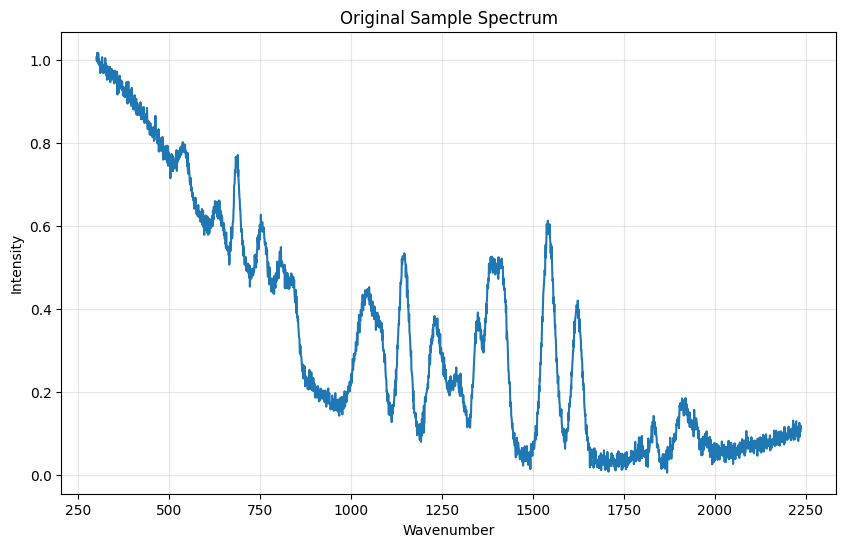

Expected spectrum length from PCA: 2179
Actual spectrum length: 2500
Truncating spectrum from 2500 to 2179 points
Input shape for PCA: (1, 2179)
PCA transformed shape: (1, 10)
Predicted normalized values: [[0.41627092 0.44300188]]
Predicted parameters:
  Lambda: 3.004044e+02
  Tau: 3.103744e-07


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Results saved to e:\Desktop\OP-airPLS\2. ML Part/results\baseline_correction_results.csv
Parameters saved to e:\Desktop\OP-airPLS\2. ML Part/results\predicted_parameters.csv


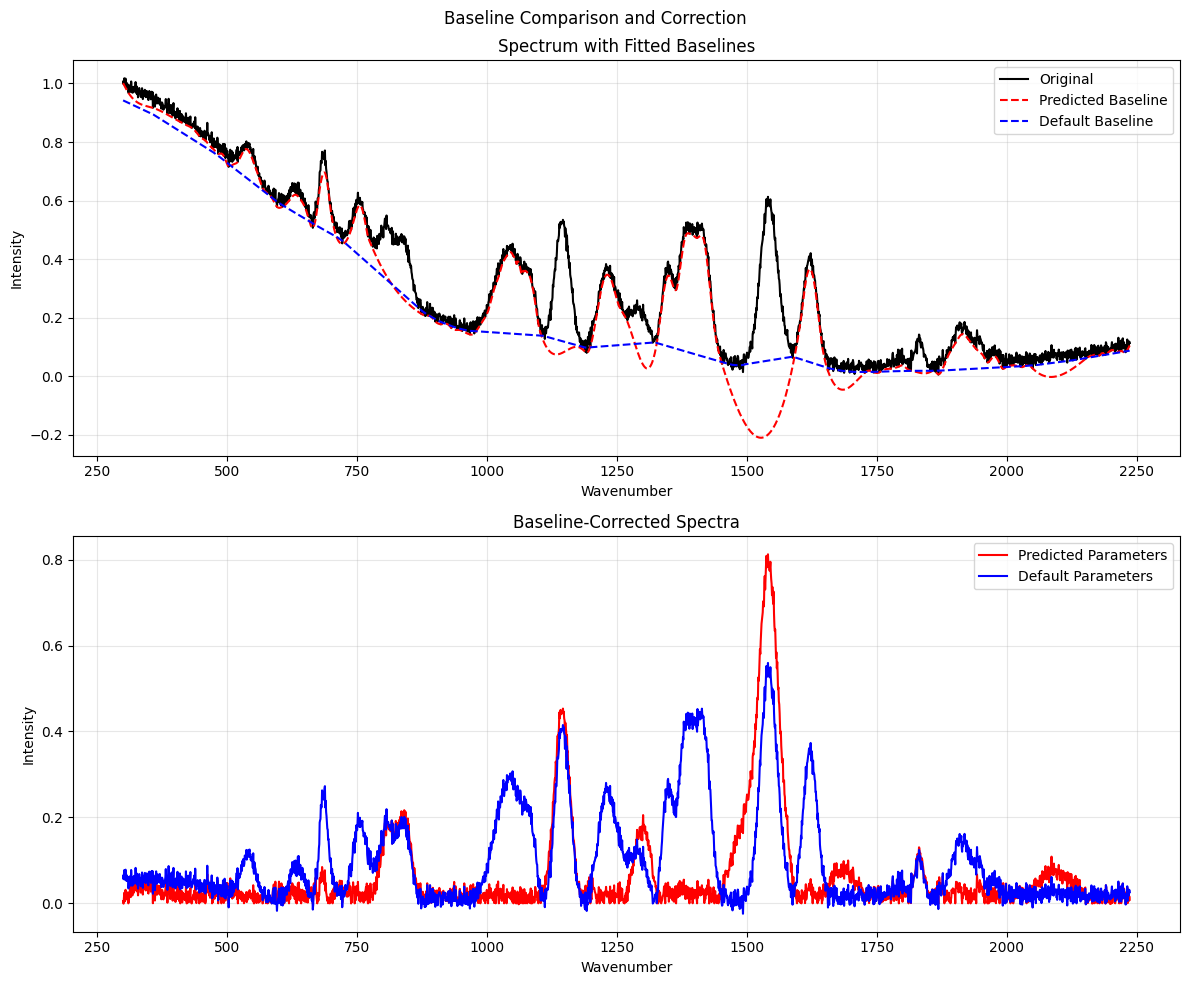


=== Processing All Spectra in the File ===

Processing 0...
Expected spectrum length from PCA: 2179
Actual spectrum length: 2500
Truncating spectrum from 2500 to 2179 points
Input shape for PCA: (1, 2179)
PCA transformed shape: (1, 10)
Predicted normalized values: [[0.41627092 0.44300188]]
Predicted parameters:
  Lambda: 3.004044e+02
  Tau: 3.103744e-07


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


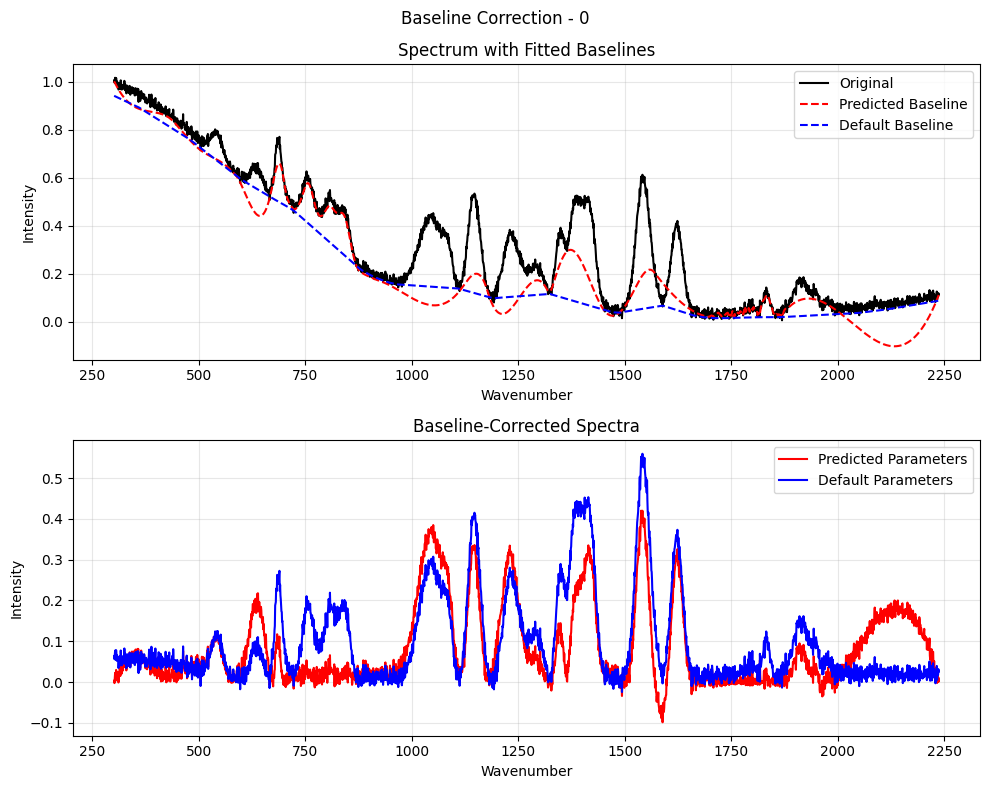


All parameters saved to e:\Desktop\OP-airPLS\2. ML Part/results\all_predicted_parameters.csv
Successfully processed 1 spectra in total.
Results saved to: e:\Desktop\OP-airPLS\2. ML Part/results


In [18]:
# Process spectrum with loaded model components
if model is None or pca is None or lambda_scaler is None or tau_scaler is None:
    print("Failed to load model components. Execution stopped.")
else:
    # Check if sample data exists
    if not os.path.exists(sample_data_path):
        print(f"Sample data not found at {sample_data_path}. Execution stopped.")
    else:
        # First process a single spectrum as an example
        print("\n=== Processing First Spectrum as Example ===")
        wavenumbers, spectrum = load_spectrum(sample_data_path, spectrum_idx=1)
        if wavenumbers is None or spectrum is None:
            print("Failed to load spectrum. Execution stopped.")
        else:
            # Plot the original spectrum
            plot_spectrum(wavenumbers, spectrum, title="Original Sample Spectrum")
            
            # Process the spectrum
            results = process_spectrum(
                wavenumbers, spectrum, model, pca, lambda_scaler, tau_scaler,
                compare_default=True, save_results=True, output_dir=output_dir
            )
            
            # Plot baseline comparison
            if results['baseline_pred'] is not None:
                plot_baseline_comparison(
                    wavenumbers, spectrum, results['baseline_pred'], results['baseline_default'],
                    title="Baseline Comparison and Correction"
                )
                
            # Automatically process all spectra in the file
            print("\n=== Processing All Spectra in the File ===")
            try:
                all_results = process_multiple_spectra(
                    sample_data_path, model, pca, lambda_scaler, tau_scaler, output_dir=output_dir
                )
                print(f"Successfully processed {len(all_results)} spectra in total.")
                print(f"Results saved to: {output_dir}")
            except Exception as e:
                print(f"Error processing multiple spectra: {str(e)}")
                print("You can still examine the individual spectrum results above.")